# Problem Description

This notebook is also based on a prompt from a coding interview. In this interview, I was asked to assess that outputs of a black-box machine learning model (that was not given) on the international stock market. An added difficulty was taking into account the daily change in foreing exchange rates, so that all stocks could be compared on a level playing field.

I have anonymized some less substantive parts of the data in this notebook for the interviewing company's privacy.

## Data Input and Data Wrangling

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

#For presentation purposes
import warnings
warnings.filterwarnings('ignore')

In [2]:
company_returns = pd.read_csv('company_returns.csv')
fx_returns = pd.read_csv('fx_returns.csv')
company_currency = pd.read_csv('company_currency.csv')

company_returns['prediction_error'] = company_returns.predicted_return-company_returns.true_return
company_returns['currency'] = company_currency.loc[company_returns.company_id].currency.values

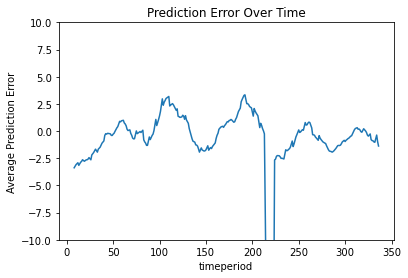

In [3]:
company_returns.groupby('timeperiod').mean().rolling(window = 7).mean().prediction_error.plot()
plt.ylim(-10,10)
plt.ylabel('Average Prediction Error')
plt.title('Prediction Error Over Time')
plt.show()

This has a big seasonality component. A simple ARMA model could improve the average prediction considerably. 

Note that this graph ignores the differences in currencies. From here on out all the analysis will be divided up by currency. I will call each of the grouped datasets ''markets.'' These will be grouped into the large markets (those will more data on more than 50 representative businesses) and small markets (those will 50 or less).

The markets will have their currency adjusted to be _proportional_ to USD at time period 0. This is why we will not focus on considering markets together. They could have very different constants of propotionality.

## EDA

### 1. Does the Model Capture the Correlation of the Businesses in Large Currency-Adjusted Markets?

In [7]:
#Large Markets are those with Common Currencies
common_currencies = []
for currency in company_returns.currency.unique():
    if type(currency) is not str:
        continue
    if company_returns.groupby('currency').company_id.nunique()[currency]>50:
        common_currencies.append(currency)

anon_names = ['Currency 1','Currency 2','Currency 3','Currency 4',
              'Currency 5','Currency 6','Currency 7','Currency 8']

def market_average(currency):
    country = company_currency[company_currency.currency == currency].company_id.tolist()
    market = company_returns[company_returns.company_id.isin(country)].groupby('timeperiod').mean()
    fx_country_R = 1+fx_returns[fx_returns.currency == currency].groupby('timeperiod').mean().true_return/100
    return fx_country_R.cumprod()*market.true_return

def market_average_model(currency):
    country = company_currency[company_currency.currency == currency].company_id.tolist()
    market = company_returns[company_returns.company_id.isin(country)].groupby('timeperiod').mean()
    fx_country_R = 1+fx_returns[fx_returns.currency == currency].groupby('timeperiod').mean().predicted_return/100
    return fx_country_R.cumprod()*market.predicted_return

market_streams = [market_average(curr) for curr in common_currencies]
market_streams = pd.DataFrame(market_streams).T
market_streams.columns = common_currencies

model_markets = [market_average_model(curr) for curr in common_currencies]
model_markets = pd.DataFrame(model_markets).T
model_markets.columns = common_currencies    

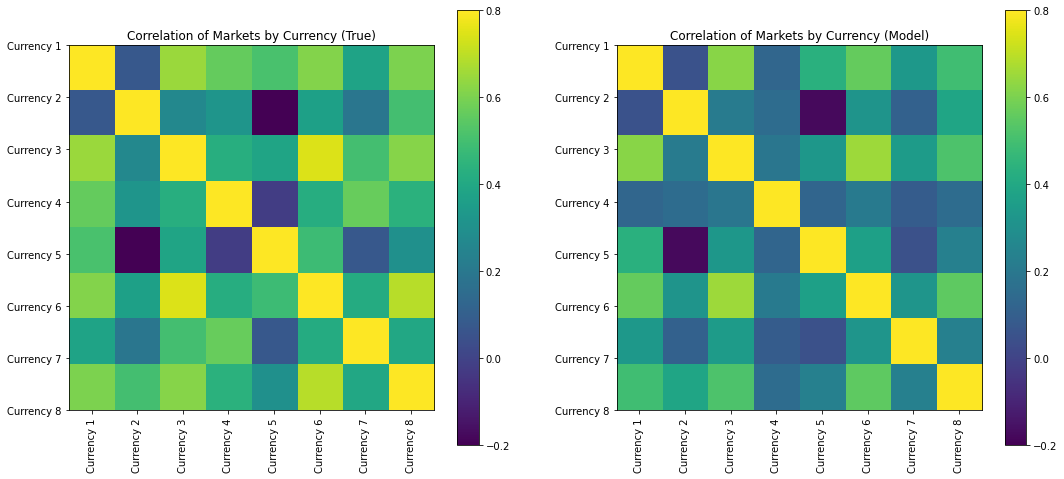

In [9]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(121)
im = ax.imshow(market_streams.corr(),vmax = .8, vmin=-.2)

ax.set_xticklabels(anon_names,rotation=90)
ax.set_yticklabels(anon_names)
ax.set_xticks(range(8))
ax.set_yticks(np.linspace(-.5,7.5,8))
fig.colorbar(im)
ax.set_title('Correlation of Markets by Currency (True)')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(model_markets.corr(),vmax = .8, vmin=-.2)

ax2.set_xticklabels(anon_names,rotation=90)
ax2.set_xticks(range(8))
ax2.set_yticks(np.linspace(-.5,7.5,8))
ax2.set_yticklabels(anon_names)
fig.colorbar(im2)
ax2.set_title('Correlation of Markets by Currency (Model)')

plt.show()

A couple of observations here. Most of the markets are positively correlated. A big exception is Currency 5 and Currency 2. The most correlated markets appear to be (Currency 3 and Currency 6) and (Currency 6 and Currency 8). The model reflects these findings, but there are some differences between the model and the true results. We explore these below.

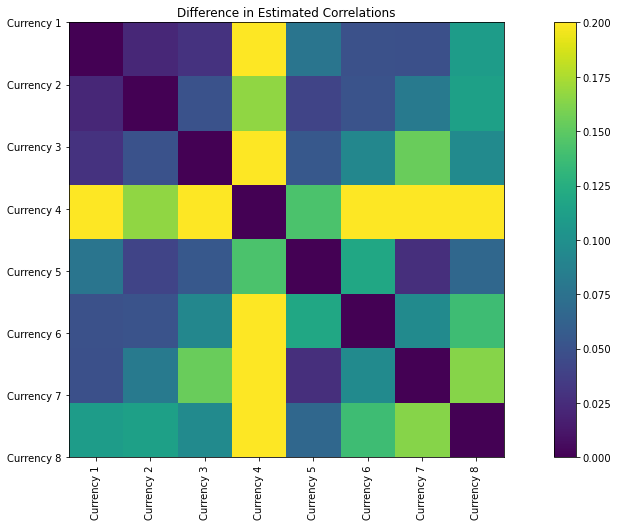

In [10]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
im = ax.imshow(np.abs(market_streams.corr()-model_markets.corr()),vmax=.2)

ax.set_xticklabels(anon_names,rotation=90)
ax.set_yticklabels(anon_names)
ax.set_xticks(range(8))
ax.set_yticks(np.linspace(-.5,7.5,8))
fig.colorbar(im)
ax.set_title('Difference in Estimated Correlations')
plt.show()

The model does a fairly good job of capturing the correlation of behavior of different markets. Where it falters most is with the currency Currency 4 and, to a much lesser extent, (Currency 7 and Currency 8) and (Currency 3 and Currency 7).

### 2.  Currency-Adjusted Market Prediction Errors as a Random Process

In [11]:
grouped_fx = fx_returns.groupby(['currency','timeperiod'])
fx_dict_true = grouped_fx.true_return.mean().to_dict()
fx_dict_pred = grouped_fx.predicted_return.mean().to_dict()
    
def calc_equivalent_true(row):
    try:
        return fx_dict_true[(row.currency,row.timeperiod)]
    except:
        return np.nan
    
def calc_equivalent_pred(row):
    try:
        return fx_dict_pred[(row.currency,row.timeperiod)]
    except:
        return np.nan

company_returns['currency_return_true'] = [calc_equivalent_true(row) for i,row in company_returns.iterrows()]
company_returns['currency_return_predicted'] = [calc_equivalent_pred(row) for i,row in company_returns.iterrows()]

In [12]:
co_groups = company_returns.groupby('company_id')
company_returns['true_adj']  = co_groups.apply(lambda co:(1+co.currency_return_true/
                                                          100).cumprod()*co.true_return).values
company_returns['pred_adj']  = co_groups.apply(lambda co:(1+co.currency_return_predicted/
                                                          100).cumprod()*co.predicted_return).values
company_returns['error_adj'] = company_returns.pred_adj-company_returns.true_adj

currency_groups = company_returns.groupby(['currency','timeperiod'])
error_by_currency = currency_groups.mean().error_adj

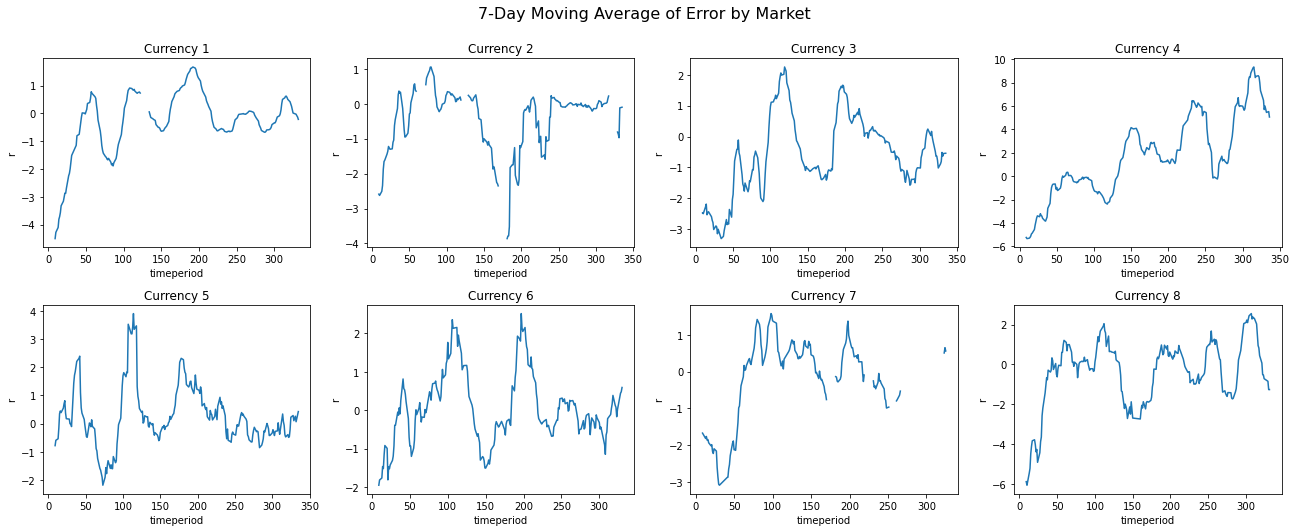

In [13]:
plt.figure(figsize = (18,7))
for i,currency in enumerate(common_currencies):
    plt.subplot(2,4,i+1)
    error_by_currency[currency].rolling(7).mean().plot()
    plt.title("Currency {}".format(i+1))
    plt.ylabel('r')
plt.tight_layout()
plt.suptitle('7-Day Moving Average of Error by Market',size=16,y=1.05)  
plt.show()

Some of the correlation talked about above is apparent here (e.g. Currency 7 and Currency 8). Note that these all have a different scale for $r$.

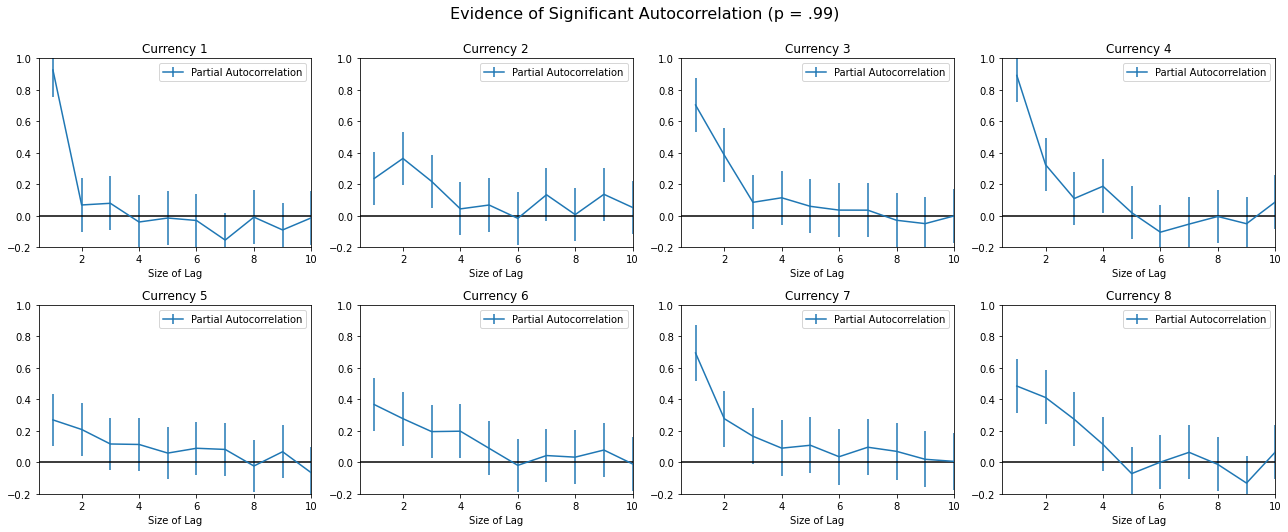

In [18]:
def show_partial_predictability(i):
    
    pts, inters = sm.tsa.pacf(error_by_currency[currency].dropna().values,10,alpha=.01)
    plt.errorbar(range(1,11),pts[1:],yerr = np.abs(inters-pts.reshape(-1,1))[1:].T, label = 'Partial Autocorrelation')
    plt.plot([.5,10],[0,0],'k')
    plt.xlabel('Size of Lag')
    plt.xlim(.5,10)
    plt.ylim(-.2,1)
    plt.title("Currency {}".format(i+1))
    plt.legend()

fig = plt.figure(figsize=(18,7))    
for i,currency in enumerate(common_currencies):
    ax = fig.add_subplot(2,4,i+1)
    show_partial_predictability(i)

plt.tight_layout()    
plt.suptitle('Evidence of Significant Autocorrelation (p = .99)',size=16,y=1.05) 
plt.show()

What these PACF plots show us if that there is a lot of regularity to the time series errors. For example, every single market has a significant pacf value for a lag of one. This means that you could just try to predict this timestep's error from the previous timestep.

From here we focus on predicting the errors, combining that with the model, and using that to make a trading portfolio.

## Trading Algorithm

From the analysis above we gather a couple things. The given model does a fine job at predicting returns.

Specifically, it does well in capturing most of the correlation between the largest markets. The exception to this, Currency 4, appears to be a submartingale over this interval, which makes it qualitatively distinct anyway. Thus, we will completely ignore interactions between markets.

Next, we see that each market is partially predictable because each is autocorrelated. As such, we will use an ARIMA model to detrend each market. These models will be picked by minimizing BIC. Then, we will use a random forest to catch any other simple patterns in the errors.

Due to the high risk in small markets, we will treat the predicted returns from these assets with more scepticism. We will model this by halving the predicted returns for positive values.

In [19]:
def arima_grid_search(data, width = 2):
    best_tup = (0,0,0)
    best_bic = np.inf
    
    for p in range(width):
        for d in range(width):
            for q in range(width):
                if p == 0 and q == 0:
                    continue
                try:
                    model = sm.tsa.ARIMA(data,(p,d,q))
                    bic = model.fit().bic
                    if bic < best_bic:
                        best_bic = bic
                        best_tup = (p,d,q)
                except:
                    pass
    
    return best_tup

In [20]:
series_list = []
for currency in common_currencies:
    temp = error_by_currency[currency].dropna()
    series_list.append(pd.Series(np.interp(range(temp.index.min(),temp.index.max()+1),
                                           temp.index.values,temp.values),
                                 index = range(temp.index.min(),temp.index.max()+1)))
data = pd.DataFrame(series_list).T.dropna()
data.columns = common_currencies

In [21]:
order_dict = dict()
fit_dict = dict()
trends = dict()
detrended_data = dict()

for currency in common_currencies:
    order_params = arima_grid_search(data[currency],3)
    arima_model = sm.tsa.ARIMA(data[currency],order_params)
    
    order_dict[currency] = order_params
    fit_dict[currency] = arima_model.fit().params
    
    if 'ARIMA' in str(type(arima_model)):
        trends[currency] = arima_model.predict(fit_dict[currency],start = data.index[0],
                                                       end = data.index[-1], typ = 'levels')
    else:
        trends[currency] = arima_model.predict(fit_dict[currency],start = data.index[0],
                                                       end = data.index[-1])
        
    detrended_data[currency] = data[currency] - trends[currency]

The PACF analysis showed significant autocorrelation for a lag of about three steps. This will be the input data to our random forest. We will start with a validation of the concept. Note that we remove the temporal element from the system, thus allowing for usual validation techniques. As there are no hyperparameters to tune, we then go straight to assembling the models.

In [22]:
#Validation. Is Random Forest Better than Martingale Guess?
errors = []
for i, currency in enumerate(common_currencies):
    x = detrended_data[currency].values
    X = np.array([x[2:-1],x[1:-2],x[:-3]]).T
    x = x[3:]
    
    cv = KFold(5)
    print('\n'+"Currency {}".format(i+1))
    for train, test in cv.split(X):
        x_c,X_c = x[train], X[train]
        y,Y = x[test], X[test]

        rf = RandomForestRegressor()
        rf.fit(X_c,x_c)
        print(round((np.abs(Y[:,0]-y).sum()/len(y))-np.abs(rf.predict(Y)-y).sum()/len(y),5), end =' ')


Currency 1
0.01068 0.00851 0.00242 -0.00363 -0.00135 
Currency 2
-0.12295 -0.0434 0.29278 0.07864 0.09898 
Currency 3
0.05838 0.01208 -0.0186 -0.01138 0.0121 
Currency 4
0.06579 -0.02806 0.06314 0.10651 0.11128 
Currency 5
-0.03765 0.04563 -0.02906 0.00406 0.0238 
Currency 6
0.11757 0.07885 0.0801 0.05203 0.03393 
Currency 7
-0.01974 0.00321 0.01769 0.02722 0.00242 
Currency 8
0.20525 0.17874 0.31847 0.18347 -0.07105 

Here positive scores are good. They mean the random forest game smaller errors than the martingale guess ($error[t+1] = error[t]$). This did not always happen. That means that this is not a great standalone predictor. So, we combine the two guessing strategies and show that this is better than the martingale guess most of the time. 

In [23]:
#Validation. Is Random Forest Better than Martingale Guess?
errors = []
for i, currency in enumerate(common_currencies):
    x = detrended_data[currency].values
    X = np.array([x[2:-1],x[1:-2],x[:-3]]).T
    x = x[3:]
    
    cv = KFold(5)
    print('\n'+"Currency {}".format(i+1))
    for train, test in cv.split(X):
        x_c,X_c = x[train], X[train]
        y,Y = x[test], X[test]

        rf = RandomForestRegressor()
        rf.fit(X_c,x_c)
        print(round((np.abs(Y[:,0]-y).sum()/len(y))-np.abs(rf.predict(Y)/2+Y[:,0]/2-y).sum()/len(y),5), end =' ')


Currency 1
0.01125 0.00551 0.00211 -0.00016 0.00124 
Currency 2
-0.01453 0.01429 0.24987 0.07054 0.0673 
Currency 3
0.0478 0.04097 0.01518 0.00871 0.01733 
Currency 4
0.07078 0.01163 0.04028 0.07537 0.08545 
Currency 5
-0.02188 0.07758 0.00617 0.01879 0.02279 
Currency 6
0.11351 0.10184 0.08788 0.05145 0.05184 
Currency 7
0.02216 0.0187 0.02664 0.02258 0.02171 
Currency 8
0.2127 0.18811 0.24438 0.13362 0.0111 

In [24]:
forests = []
for currency in common_currencies:
    x = detrended_data[currency]
    X = np.array([x[2:-1],x[1:-2],x[:-3]]).T

    rf = RandomForestRegressor()
    rf.fit(X,x[3:])
    forests.append(rf)

We now compile our full model. This function is never run, but it is written to be able to be run given the right data inputs (1. A dictionary of the given model's current guesses for corporate return * FX return with companies as keys. 2. Past data in a dataframe with the same columns as _company returns_ in this notebook.). It is written to run company by company, but could also run like the above analysis and group all the companies by currency. Read more about investment strategies below.

In [25]:
def full_model(given_model, past_data):
    output_dict = dict()
    
    for company in given_model.company_id.unique():
        
        company_df = past_data[past_data == company]
        
        #Small Market Case
        if company_df.currency.unique() not in common_currencies:
            output_dict[company] = given_model[company]/2
            continue
        
        #Start of Large Market Case
        currency_groups = company_df.groupby(['timeperiod'])
        error_by_time = currency_groups.mean().error_adj.dropna()
        time_ind = error_by_time.index
        
        #Gathering the Right Input Data
        data = pd.Series(np.interp(range(time_ind.min(),time_ind.max()+1),
                                               time_ind.values,error_by_time.values),
                                     index = range(time_ind.min(),time_ind.max()+1))
        
        #Create ARIMA Model
        order_params = arima_grid_search(data,3)
        arima_model = sm.tsa.ARIMA(data[currency],order_params)
        params = arima_model.fit().params

        if 'ARIMA' in str(type(arima_model)):
            trend = arima_model.predict(params,start = data.index[0], end = data.index[-1],
                                        typ = 'levels')
        else:
            trend = arima_model.predict(params,start = data.index[0], end = data.index[-1])

        detrended_data = data - trend
        
        #Create ML Model
        x = detrended_data[currency]
        X = np.array([x[2:-1],x[1:-2],x[:-3]]).T

        rf = RandomForestRegressor()
        rf.fit(X,x[3:])
        
        current_input = error_by_time[-3:][::-1]
        current_timeperiod = time_ind.max()+1
        
        #Combine Predictions
        if 'ARIMA' in str(type(arima_model)):
            output_dict.append(given_model[company] +\
                               arima_model.predict(params,[current_timeperiod],typ='levels')[0] +\
                               rf.predict([current_input])[0]/2+error_by_time[-1]/2)
        else:
            output_dict.append(given_model[company] +\
                               arima_model.predict(params,[current_timeperiod])[0] +\
                               rf.predict([current_input])[0]/2+error_by_time[-1]/2)
            
    return output_dict

As for using these expected returns in a trading strategy. I would start off by doing a CAPM for each market individually, calculate $\beta$ for each company and go from there to do option valuation. Depending on availability in each market, I would do a delta hedge or a volatility arbitage based strategy. These could be executed quickly/algorithmicly.

On the other hand, one could create a machine learning strategy as long as a robust simulation environment was built. Then, we would be open to all sorts of interesting pathways, including reinforcement learning and stochastic optimization.